# Keras Seq2Seq Formality Transfer Model

References:
- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py
- https://github.com/lukas/ml-class/blob/master/videos/cnn-text/imdb-embedding.py

## TODO

- Experiment with LSTM/GRU effectiveness
- Experiment with attention
- Probabilistic sampling

In [3]:
from keras.layers import Embedding, LSTM, TimeDistributed, RepeatVector, Dense, Lambda, Softmax
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing import text, sequence
from keras.models import Sequential
import tensorflow as tf


%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from IPython import display

import urllib.request
import numpy as np
import progressbar
import zipfile
import time
import os

## Load Training Data


In [4]:
num_samples = None

with open("labelled.txt", "r") as l:
    raw_data = l.read()
lines = [x.strip() for x in raw_data.split("\n")]
max_length = max(len(i) for i in lines)

X = []
Y = []
for i in range(0, len(lines)-1 if num_samples is None else min(len(lines)-1,num_samples*2), 2):
    X.append(lines[i])
    Y.append(lines[i+1])


train_prop = 0.9
train_num = int(train_prop * len(X))

X_train, X_test = X[:train_num], X[train_num:]
Y_train, Y_test = Y[:train_num], Y[train_num:]

## Load GloVe Embeddings


In [5]:
# https://nlp.stanford.edu/projects/glove/
glove_zip = "glove.6B.zip"
glove_txt = "glove.6B.50d.txt"
vocab_size = 40000
embedding_dim = 50

if not os.path.isfile(glove_txt):
    pbar = None
    def show_progress(block_num, block_size, total_size):
        global pbar
        if pbar is None:
            pbar = progressbar.ProgressBar(maxval=total_size)
            pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            pbar.update(downloaded)
        else:
            pbar.finish()
            pbar = None

    url = f"http://nlp.stanford.edu/data/{glove_zip}"
    urllib.request.urlretrieve(url, glove_zip, show_progress)
    with zipfile.ZipFile(glove_zip, "r") as zip_ref:
        zip_ref.extractall(".")

In [6]:
tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train + Y_train)

X_train_arr = tokenizer.texts_to_sequences(X_train)
X_test_arr = tokenizer.texts_to_sequences(X_test)
Y_train_arr = tokenizer.texts_to_sequences(Y_train)
Y_test_arr = tokenizer.texts_to_sequences(Y_test)

X_train_arr = sequence.pad_sequences(X_train_arr, maxlen=max_length)
X_test_arr = sequence.pad_sequences(X_test_arr, maxlen=max_length)
Y_train_arr = sequence.pad_sequences(Y_train_arr, maxlen=max_length)
Y_test_arr = sequence.pad_sequences(Y_test_arr, maxlen=max_length)

embeddings_index = dict()
with open(glove_txt, encoding="utf8") as f:
    for line in f.read().split("\n"):
        if line == "":
            break
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype="float32")
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

embedding_matrix_inverse = tf.linalg.pinv(embedding_matrix)

## Define Model

In [7]:
hidden_size = 256
checkpoints_dir = os.path.abspath("keras-checkpoints")

# (None, max_length) ->
# (None, max_length, embedding_dim) ->
# (None, hidden_dim) ->
# (None, max_length, hidden_dim) ->
# (None, max_length, hidden_dim) ->
# (None, max_length, embedding_dim) ->
# (None, max_length, vocab_size) ->

model = Sequential()
model.add(embedding_layer:=Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(LSTM(hidden_size, input_shape=(max_length, embedding_dim)))
model.add(RepeatVector(max_length))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(TimeDistributed(Dense(embedding_dim, activation="softmax")))
model.add(Lambda(lambda x: Softmax()(tf.matmul(x,embedding_matrix_inverse)), output_shape=(None, max_length, vocab_size)))

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 50)           2000000   
                                                                 
 lstm (LSTM)                 (None, 256)               314368    
                                                                 
 repeat_vector (RepeatVector  (None, 600, 256)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 600, 256)          525312    
                                                                 
 time_distributed (TimeDistr  (None, 600, 50)          12850     
 ibuted)                                                         
                                                                 
 lambda (Lambda)             (None, 600, 40000)        0

## Configure Graph

In [8]:
class Plotter(Callback):
    id_counter = 0

    def __init__(self):
        super().__init__()
        self.id = f"plot-{Plotter.id_counter}"
        Plotter.id_counter += 1
        self.fig, self.ax = plt.subplots(figsize=(24, 6), dpi=80)
        self.ax.set_xlabel("Epoch")
        self.ax.set_ylabel("Loss")
        self.ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10.0))
        self.ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=1.0))
        # self.ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
        # self.ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.02))
        self.ax.grid(which="major", color="#888888")
        self.ax.grid(which="minor", color="#bbbbbb")

        self.fig.patch.set_facecolor("white")
        box = self.ax.get_position()
        self.ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        display.display(self.fig, display_id=self.id)

        self.max_loss = -1

        self.epochs = []
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        for l in self.ax.lines:
            l.remove()
        
        self.epochs.append(epoch)
        self.train_losses.append(t_loss:=logs["loss"])
        self.val_losses.append(v_loss:=logs["val_loss"])

        self.max_loss = max(self.max_loss, t_loss, v_loss)
        
        t_line, = self.ax.plot(self.epochs, self.train_losses, c="#55CDFC")
        v_line, = self.ax.plot(self.epochs, self.val_losses, c="#F7A8B8")
        self.ax.autoscale()
        self.ax.set_ylim(0, self.max_loss * 1.1)
        self.ax.legend([t_line, v_line], ["Training", "Validation"], loc='center left', bbox_to_anchor=(1, 0.5))
        display.update_display(self.fig, display_id=self.id)

## Delete Existing Checkpoints &mdash; WARNING


In [20]:
if not os.path.isdir(checkpoints_dir):
    os.makedirs(checkpoints_dir)

for f in os.listdir(checkpoints_dir):
    os.unlink(os.path.join(checkpoints_dir, f))

## Train

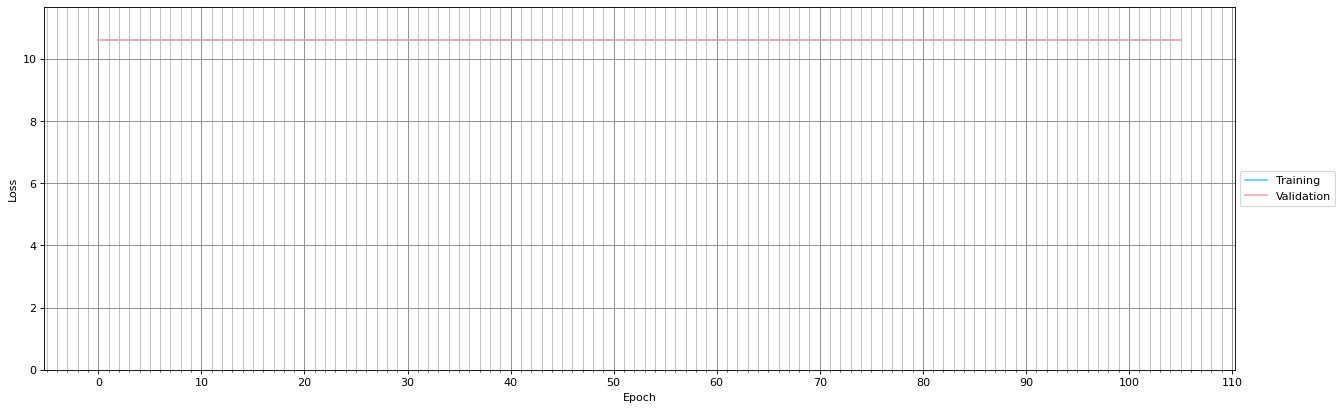

Epoch 1/1000
225/225 [==============================] - 43s 190ms/step - loss: 10.5966 - accuracy: 9.2593e-07 - val_loss: 10.5966 - val_accuracy: 0.0000e+00
Time for Epoch: 42.91s, Total Elapsed: 42.91s, Total ETA: 11.91hr
"You should seek advice from a medical professional." -> "myoclonic myoclonic myoclonic myoclonic myoclonic ..."

Epoch 2/1000
225/225 [==============================] - 47s 210ms/step - loss: 10.5966 - accuracy: 9.2593e-07 - val_loss: 10.5966 - val_accuracy: 0.0000e+00
Time for Epoch: 47.53s, Total Elapsed: 1.51min, Total ETA: 12.54hr
"You should seek advice from a medical professional." -> "myoclonic myoclonic myoclonic myoclonic myoclonic ..."

Epoch 3/1000
225/225 [==============================] - 47s 207ms/step - loss: 10.5966 - accuracy: 9.2593e-07 - val_loss: 10.5966 - val_accuracy: 0.0000e+00
Time for Epoch: 46.78s, Total Elapsed: 2.29min, Total ETA: 12.67hr
"You should seek advice from a medical professional." -> "myoclonic myoclonic myoclonic myoclonic myo

KeyboardInterrupt: 

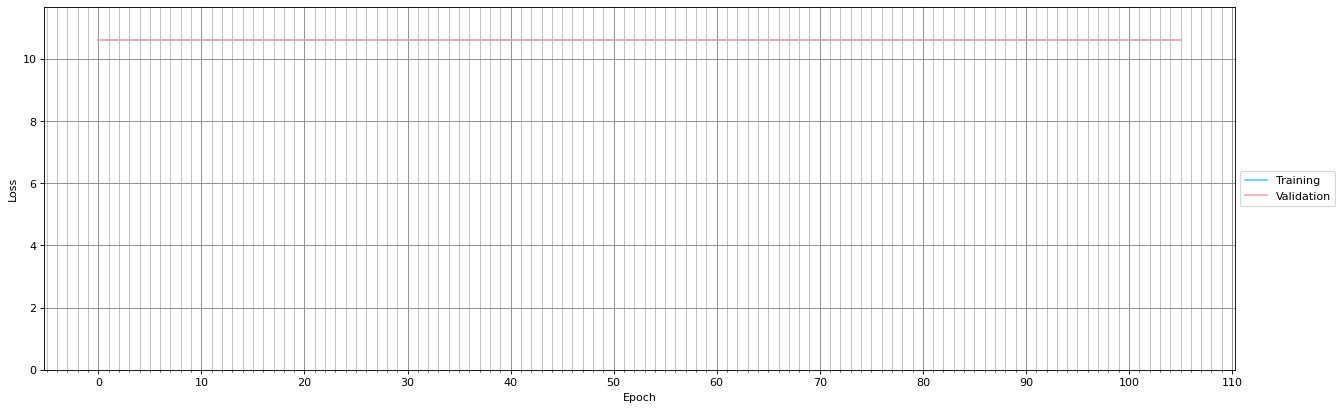

In [21]:
batch_size = 8
epochs = 1000

demo_str = "You should seek advice from a medical professional."
demo_vec = tokeninzer.texts_to_sequences([demo_str])
demo_vec = sequence.pad_sequences(demo_vec, maxlen=max_length)

filepath = os.path.join(checkpoints_dir, "formal2casual-{epoch:02d}-{loss:.4f}.ckpt")
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, monitor="loss", verbose=0, save_best_only=True, mode="min")

class PrintDemo(Callback):
    def __init__(self):
        super().__init__()
        self.start_time = time.time()
        self.last_time = self.start_time
    
    def format_time(self, seconds):
        if seconds < 60:
            return f"{seconds:.2f}s"
        elif seconds < 3600:
            return f"{(seconds/60):.2f}min"
        else:
            return f"{(seconds/3600):.2f}hr"

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            return
        now = time.time()
        elapsed = now-self.start_time
        pred_vec = np.argmax(self.model.predict(demo_vec, verbose=0), axis=-1)
        pred_str = tokenizer.sequences_to_texts(pred_vec)[0].strip()
        max_preview_length = 50
        preview = (pred_str[:max_preview_length] + '...') if len(pred_str) > max_preview_length else pred_str

        print(f"Time for Epoch: {self.format_time(now-self.last_time)}, Total Elapsed: {self.format_time(elapsed)}, Total ETA: {self.format_time(elapsed/epoch * (epochs-epoch))}")
        print(f"\"{demo_str}\" -> \"{preview}\"\n")
        self.last_time = now

model.fit(
    X_train_arr,
    Y_train_arr,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test_arr, Y_test_arr),
    callbacks=[Plotter(), checkpoint, PrintDemo()]
)

    

## Load Checkpoint

In [9]:
latest = tf.train.latest_checkpoint(checkpoints_dir)
model.load_weights(latest)

## Test

In [10]:
test_str = "You should seek advice from a medical professional."
start = time.time()
test_vec = tokenizer.texts_to_sequences([test_str])
test_vec = sequence.pad_sequences(test_vec, maxlen=max_length)
pred_vec = np.argmax(model.predict(test_vec, verbose=0), axis=-1)

pred_str = tokenizer.sequences_to_texts(pred_vec)[0].strip()

elapsed = time.time() - start
print(test_str)
print("->")
print(pred_str)
print(f"Took {elapsed:5f} seconds")

You should seek advice from a medical professional.
->
myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myoclonic myocl